In [ ]:
# SELECT country, IF(rand() <0.5, 'Group A', 'Group B') as type
# FROM `bigquery-public-data.world_bank_global_population.population_by_country`

# BQML Data prep for casual impact example

In [1]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
LOCATION = 'us-central1'
REGION = "us-central1"

# VERTEX_SA = '934903580331-compute@developer.gserviceaccount.com'
VERTEX_SA = 'jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"LOCATION: {LOCATION}")
print(f"REGION: {REGION}")
print(f"VERTEX_SA: {VERTEX_SA}")

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
LOCATION: us-central1
REGION: us-central1
VERTEX_SA: jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com


In [2]:
REGION = 'us-central1'
EXPERIMENT = 'control_group1'
SERIES = 'causal_impact_2'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

BQ_SOURCE1 = 'bigquery-public-data.new_york.citibike_trips'
BQ_SOURCE2 = 'bigquery-public-data.new_york.citibike_stations'
viz_limit = 12

### packages

In [3]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

from google.cloud import aiplatform as vertex_ai

In [4]:
bq_client = bigquery.Client(project=PROJECT_ID)

vertex_ai.init(
    project=PROJECT_ID, 
    location=REGION,
    # credentials=credentials
)

### BQ dataset

In [5]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
ds.location = 'us' #REGION
ds.labels = {'notebook': f"{EXPERIMENT}"}
ds = bq_client.create_dataset(dataset = ds, exists_ok = True)

In [6]:
ds.dataset_id

'causal_impact_2'

In [7]:
ds.full_dataset_id

'hybrid-vertex:causal_impact_2'

In [8]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE1}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

tripduration                 starttime                  stoptime  \
0           107 2014-06-06 13:02:01+00:00 2014-06-06 13:03:48+00:00   
1          1105 2013-08-24 17:03:52+00:00 2013-08-24 17:22:17+00:00   
2           990 2014-04-25 11:52:28+00:00 2014-04-25 12:08:58+00:00   
3           138 2015-08-20 16:58:57+00:00 2015-08-20 17:01:16+00:00   
4            78 2014-09-13 13:18:36+00:00 2014-09-13 13:19:54+00:00   

   start_station_id start_station_name  start_station_latitude  \
0               520    W 52 St & 5 Ave               40.759923   
1               520    W 52 St & 5 Ave               40.759923   
2               520    W 52 St & 5 Ave               40.759923   
3               520    W 52 St & 5 Ave               40.759923   
4               520    W 52 St & 5 Ave               40.759923   

   start_station_longitude  end_station_id end_station_name  \
0               -73.976485             520  W 52 St & 5 Ave   
1               -73.976485             520  W 52 St & 5 Ave   
2               -73.976485             520  W 52 St & 5 Ave   
3               -73.976485             520  W 52 St & 5 Ave   
4               -73.976485             520  W 52 St & 5 Ave   

   end_station_latitude  end_station_longitude  bikeid    usertype  \
0             40.759923             -73.976485   16692  Subscriber   
1             40.759923             -73.976485   15352    Customer   
2             40.759923             -73.976485   20194  Subscriber   
3             40.759923             -73.976485   21002  Subscriber   
4             40.759923             -73.976485   19259    Customer   

   birth_year   gender  
0        1977     male  
1        <NA>  unknown  
2        1973     male  
3        1977     male  
4        <NA>  unknown

In [9]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE2}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

station_id                        name short_name   latitude  longitude  \
0        495            W 47 St & 10 Ave    6824.07  40.762699 -73.993012   
1       3171     Amsterdam Ave & W 82 St    7360.10  40.785247 -73.976673   
2       3603              31 Ave & 30 St    6857.09  40.764700 -73.924031   
3       3733          Avenue C & E 18 St    5769.04  40.730563 -73.973984   
4       3792  Columbus Dr at Exchange Pl      JC106  40.716870 -74.032810   

   region_id   rental_methods  capacity  eightd_has_key_dispenser  \
0         71  KEY, CREDITCARD         0                     False   
1         71  KEY, CREDITCARD         0                     False   
2         71  KEY, CREDITCARD         0                     False   
3         71  KEY, CREDITCARD         0                     False   
4         70  KEY, CREDITCARD         0                     False   

   num_bikes_available  num_bikes_disabled  num_docks_available  \
0                    0                   0                    0   
1                    0                   0                    0   
2                    0                   0                    0   
3                    0                   0                    0   
4                    0                   0                    0   

   num_docks_disabled  is_installed  is_renting  is_returning  \
0                   0          True        True          True   
1                   0         False       False         False   
2                   0         False       False         False   
3                   0         False       False         False   
4                   0         False       False         False   

   eightd_has_available_keys             last_reported  
0                      False 1970-01-02 00:00:00+00:00  
1                      False 1970-01-02 00:00:00+00:00  
2                      False 1970-01-02 00:00:00+00:00  
3                      False 1970-01-02 00:00:00+00:00  
4                      False 1970-01-02 00:00:00+00:00

In [21]:
# station="Pershing Square"
station="Broadway"

In [22]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
WITH
    STATION AS (
        SELECT
           start_station_name,
           EXTRACT(DATE FROM starttime) AS starttime,
           COUNT(*) AS num_trips,
           AVG(tripduration) as avg_tripduration,
           COUNTIF(usertype='Subscriber')/COUNT(*) as pct_subscriber,
           SAFE_DIVIDE(COUNTIF(gender='male'), COUNTIF(gender!='male')) as ratio_gender,
        FROM `{BQ_SOURCE1}`
        WHERE start_station_name LIKE '%{station}%'
        GROUP BY start_station_name, starttime
    ),
    STATION_INFO AS (
        SELECT
            name,
            max(capacity) as capacity
        FROM `{BQ_SOURCE2}`
        WHERE name LIKE '%{station}%'
        GROUP BY name
    )
SELECT * EXCEPT(name)
FROM STATION A
LEFT OUTER JOIN STATION_INFO B
ON A.start_station_name = B.name
ORDER BY start_station_name, starttime
"""
job = bq_client.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

2.266

In [23]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty
CONTROL_GROUP='control_group'

In [24]:
query = f"""
    SELECT {SERIES_COLUMN}, sum({TARGET_COLUMN}) as {TARGET_COLUMN}, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq_client.query(query).to_dataframe()
overview.head(viz_limit)

start_station_name  num_trips    FromDate      ToDate
0     Boerum St & Broadway       4560  2015-08-20  2016-09-30
1    Broadway & Battery Pl     104126  2013-07-01  2016-09-30
2      Broadway & Berry St      32013  2013-07-01  2016-09-30
3       Broadway & E 14 St     244420  2013-07-01  2016-09-30
4       Broadway & E 22 St     237394  2013-07-01  2016-09-30
5   Broadway & Roebling St       8836  2015-11-06  2016-09-30
6       Broadway & W 24 St     211713  2013-07-01  2016-09-30
7       Broadway & W 29 St     132500  2013-07-01  2016-09-30
8       Broadway & W 32 St     138812  2013-07-01  2016-09-30
9       Broadway & W 36 St      76901  2013-07-01  2016-09-30
10      Broadway & W 37 St      75247  2013-07-01  2016-09-30
11      Broadway & W 39 St      94276  2013-07-01  2016-09-30

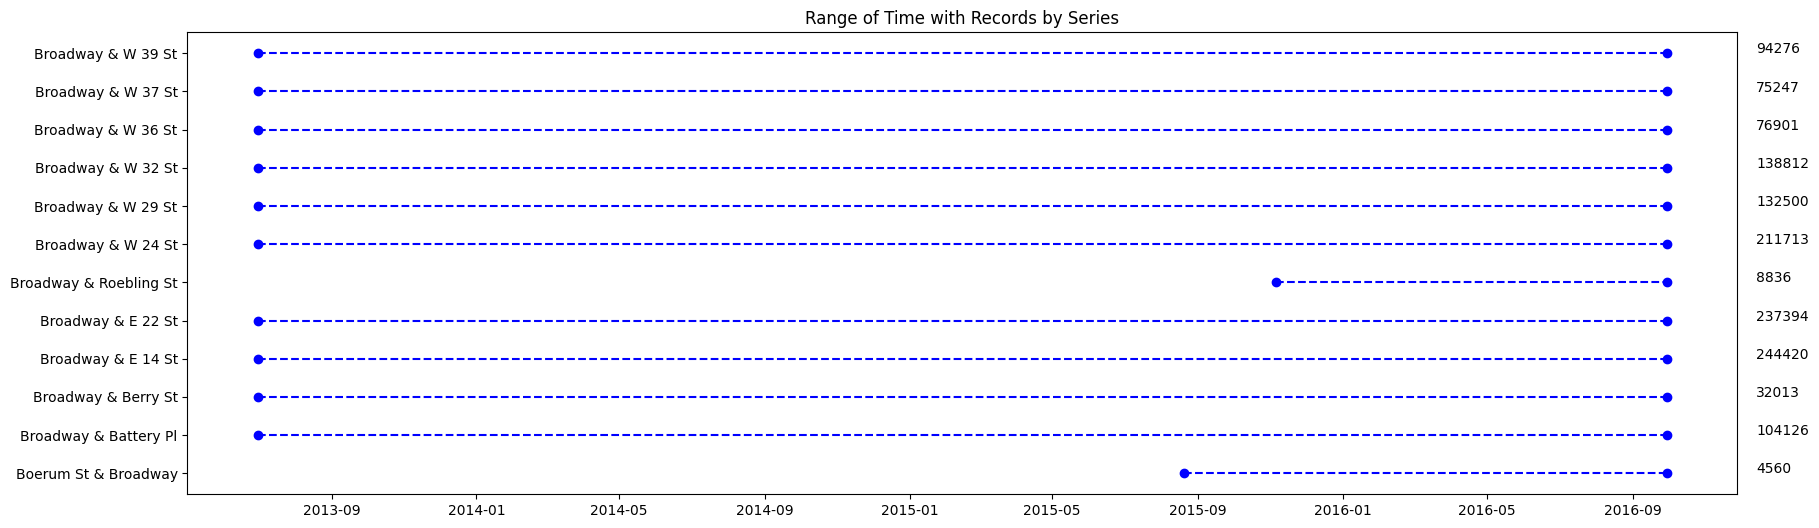

In [25]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records by Series')
plt.show()

In [26]:
query = f"""
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
dates = bq_client.query(query).to_dataframe()

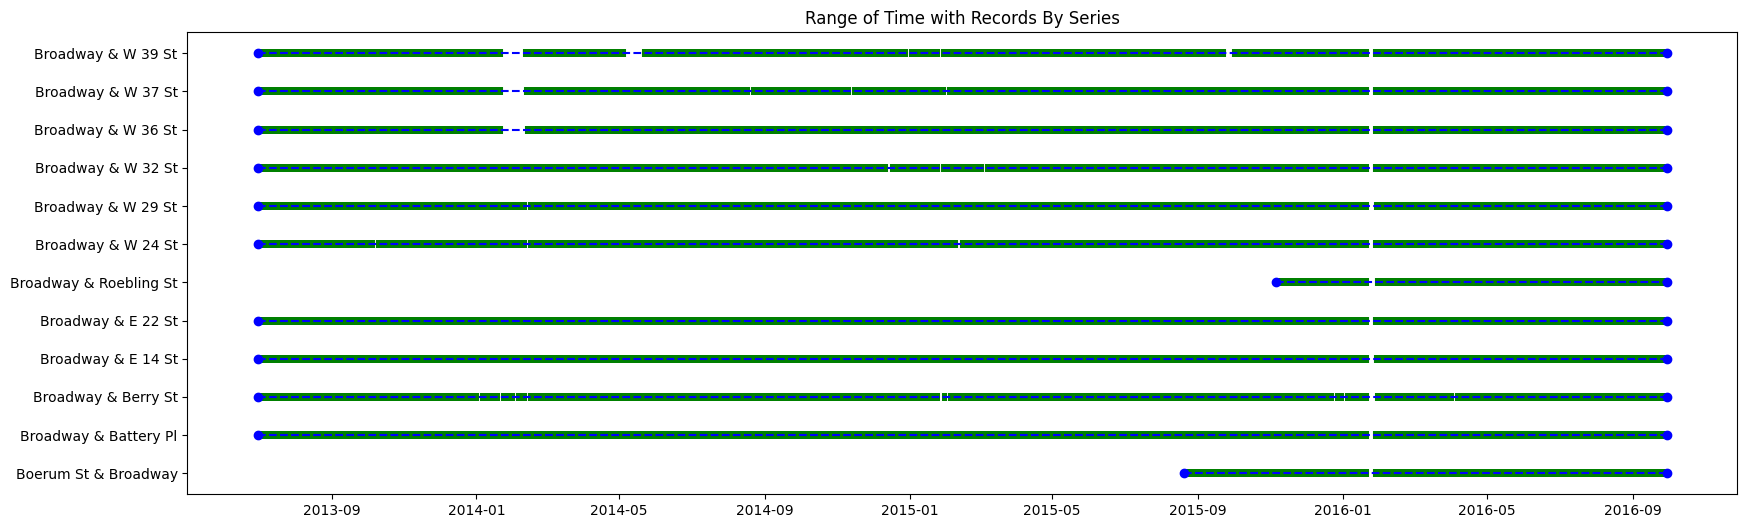

In [27]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    # subset dates to current series and plot dates with records on timelines for each series:
    tempdates = dates[(dates[SERIES_COLUMN] == overview[SERIES_COLUMN][i])]
    plt.scatter(tempdates[TIME_COLUMN], tempdates[SERIES_COLUMN], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

### Splits and Control Groups

In [28]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
forecast_val_length = 14

CONTROL_GROUP='control_group'

In [30]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date,
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`  
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

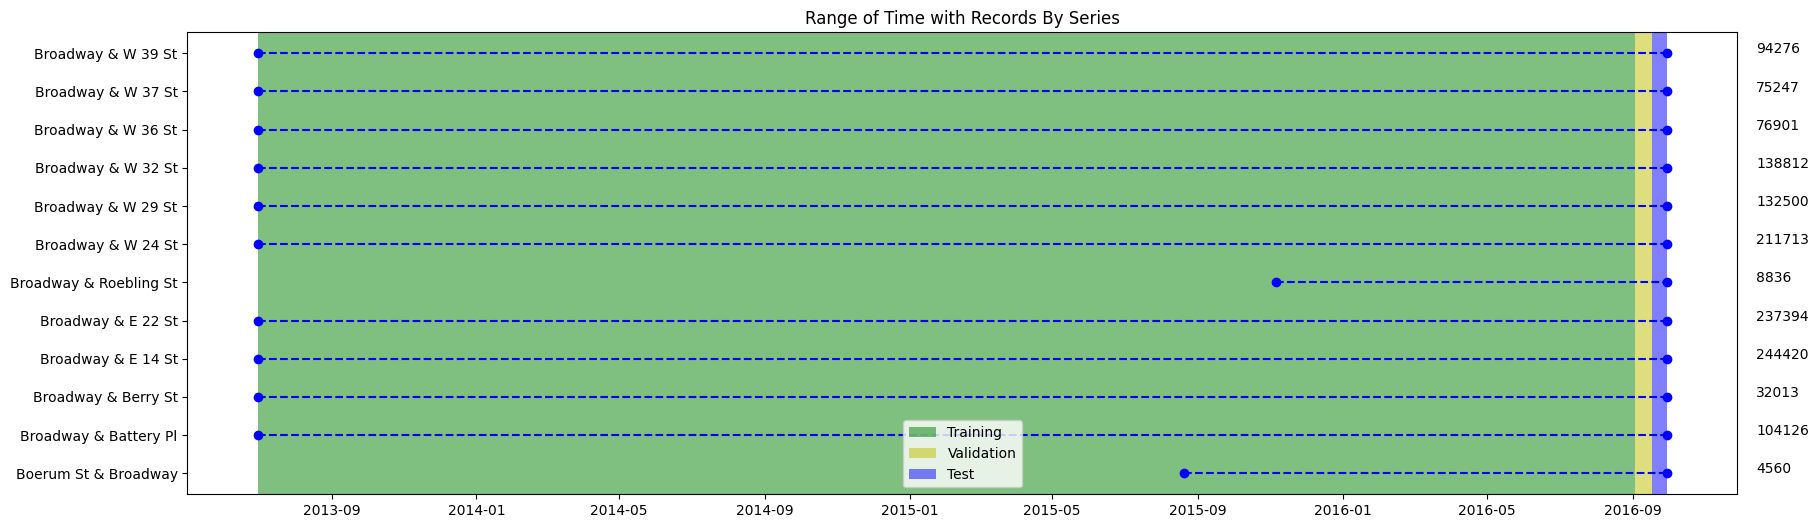

In [31]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

## Create BigQuery Table for Forecasting

In [32]:
CONTROL_GROUP='control_group'

In [33]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS splits,
       IF(rand() <0.5, 'Group_A', 'Group_B') as {CONTROL_GROUP}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
job = bq_client.query(query)
job.result()
(job.ended-job.started).total_seconds()

1.807

### review forecasting data

In [34]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        COUNTIF({CONTROL_GROUP}='Group_A') as Group_A,
        COUNTIF({CONTROL_GROUP}='Group_B') as Group_B,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

start_station_name  TRAIN  VALIDATE  TEST  Group_A  Group_B  num_trips
0     Boerum St & Broadway    376        14    14      198      206       4560
1    Broadway & Battery Pl   1155        14    14      558      625     104126
2      Broadway & Berry St   1134        14    14      599      563      32013
3       Broadway & E 14 St   1155        14    14      594      589     244420
4       Broadway & E 22 St   1156        14    14      582      602     237394
5   Broadway & Roebling St    296        14    14      155      169       8836
6       Broadway & W 24 St   1150        14    14      562      616     211713
7       Broadway & W 29 St   1154        14    14      611      571     132500
8       Broadway & W 32 St   1151        14    14      580      599     138812
9       Broadway & W 36 St   1135        14    14      609      554      76901
10      Broadway & W 37 St   1134        14    14      606      556      75247
11      Broadway & W 39 St   1116        14    14      593      551      94276

In [36]:
query = f"""
SELECT splits, count(*) as Count, 100*count(*) / (sum(count(*)) OVER()) as Percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
GROUP BY splits
"""
bq_client.query(query = query).to_dataframe()

splits  Count  Percentage
0     TRAIN  33032   96.822605
1      TEST    538    1.576973
2  VALIDATE    546    1.600422

In [38]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       33032
VALIDATE      546
TEST          538
dtype: int64

In [39]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

34116

In [37]:
query = f"""
SELECT {CONTROL_GROUP}, count(*) as Count, 100*count(*) / (sum(count(*)) OVER()) as Percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
GROUP BY {CONTROL_GROUP}
"""
bq_client.query(query = query).to_dataframe()

control_group  Count  Percentage
0       Group_A  17117   50.172939
1       Group_B  16999   49.827061

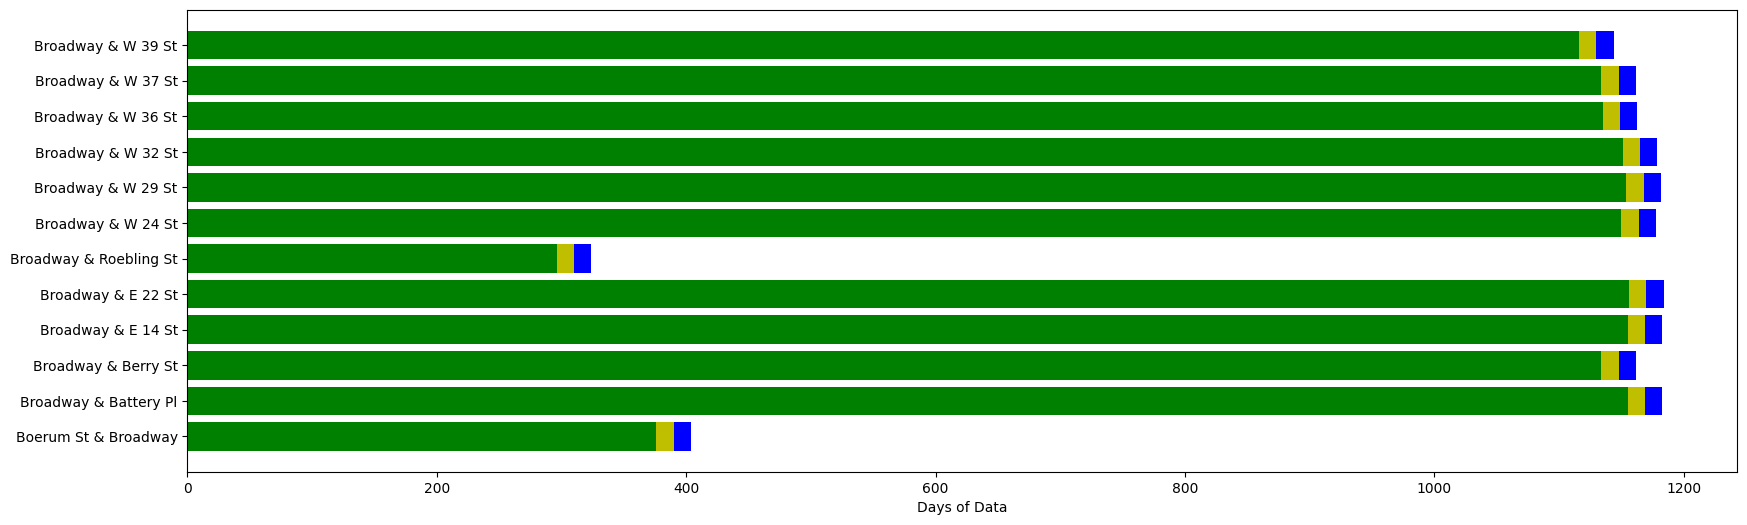

In [40]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

In [41]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

### check for duplicates

In [42]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq_client.query(query).to_dataframe()

Empty DataFrame
Columns: [start_station_name, starttime, records]
Index: []

## review time series

In [43]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, splits,
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq_client.query(query).to_dataframe()

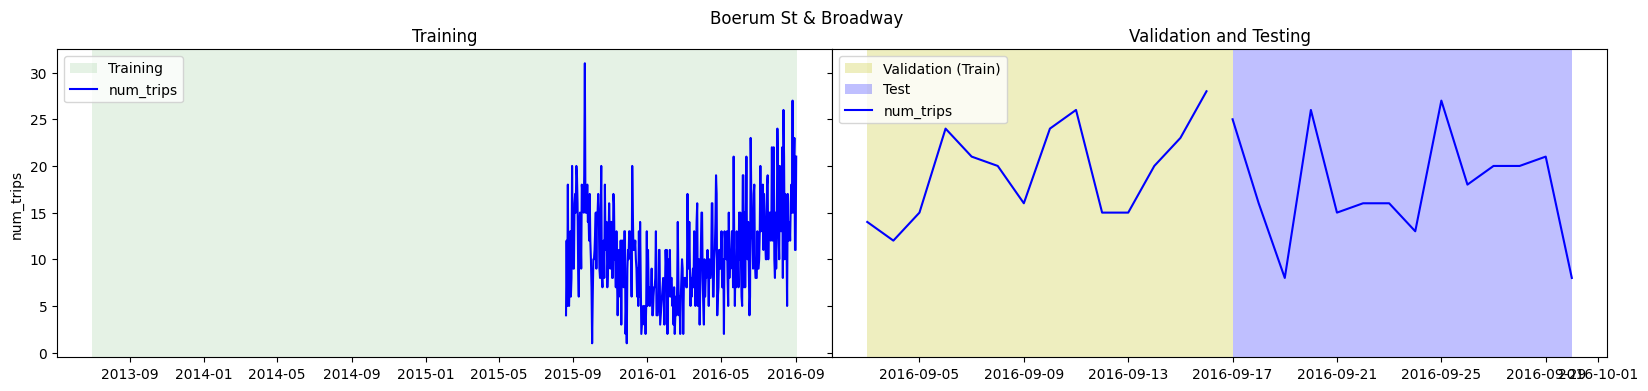

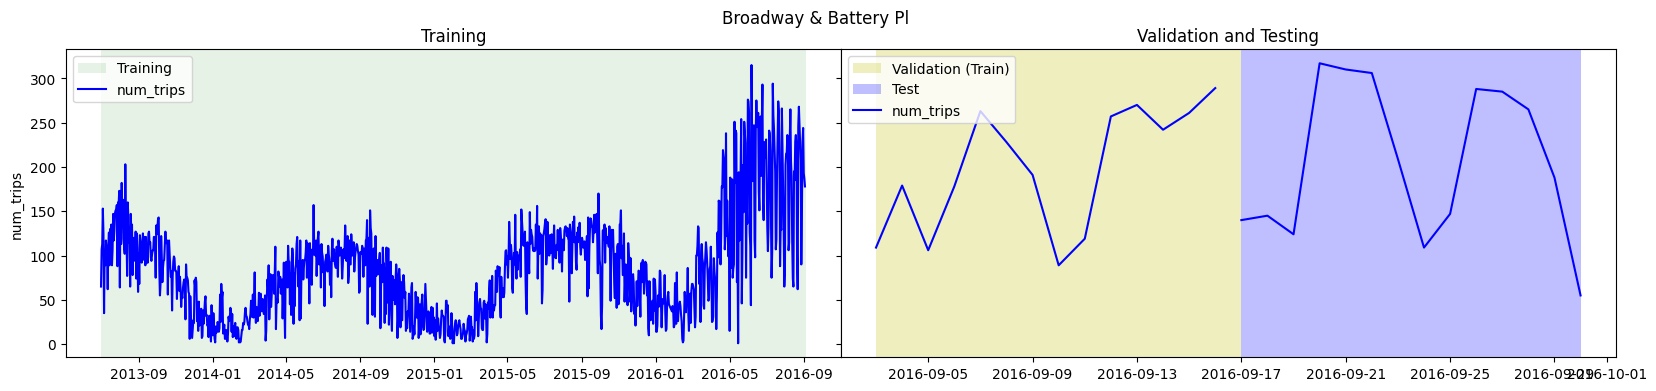

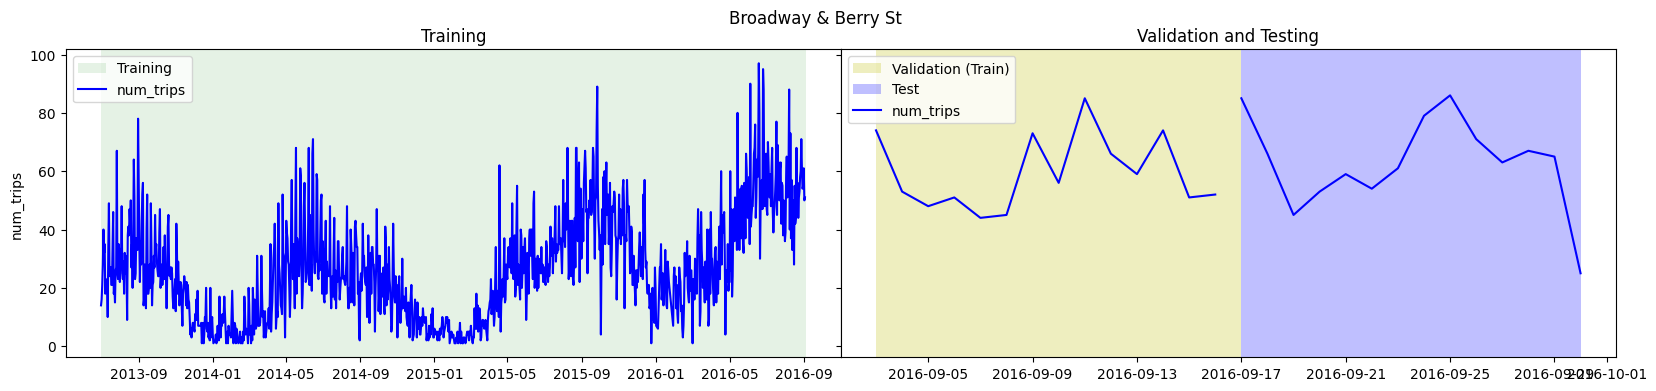

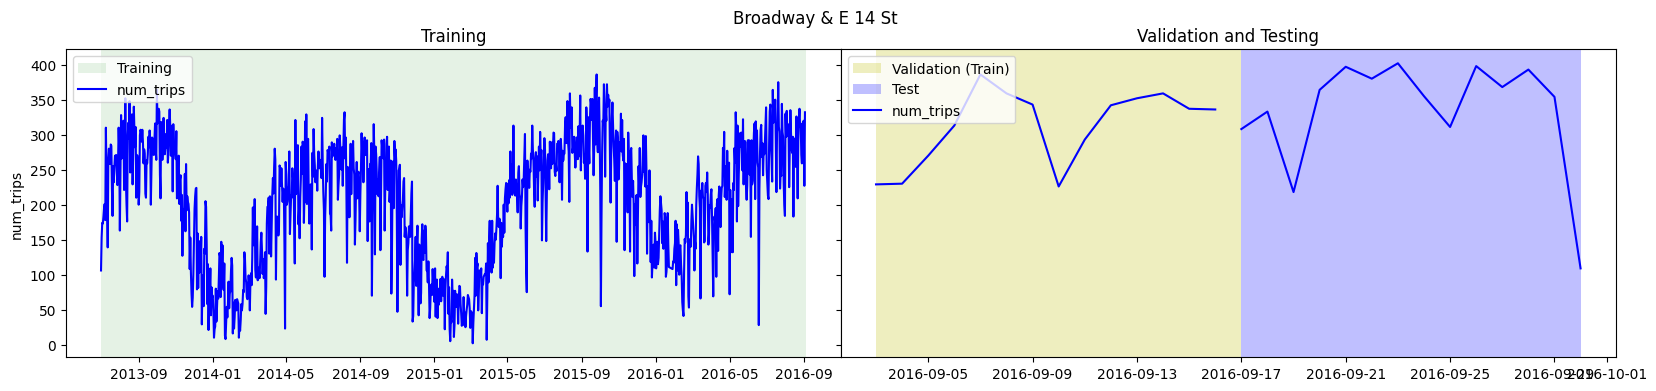

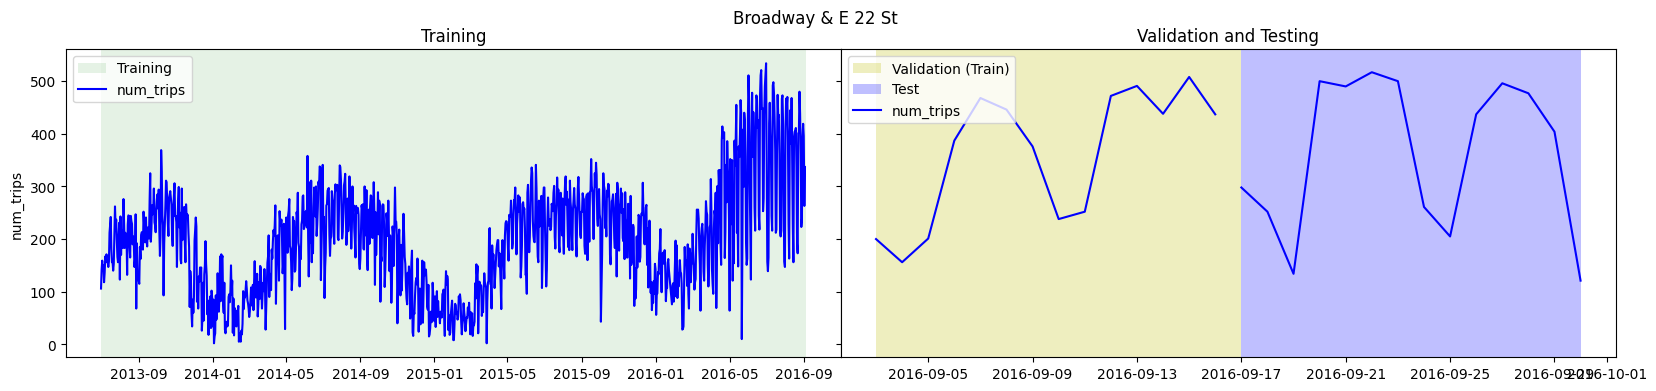

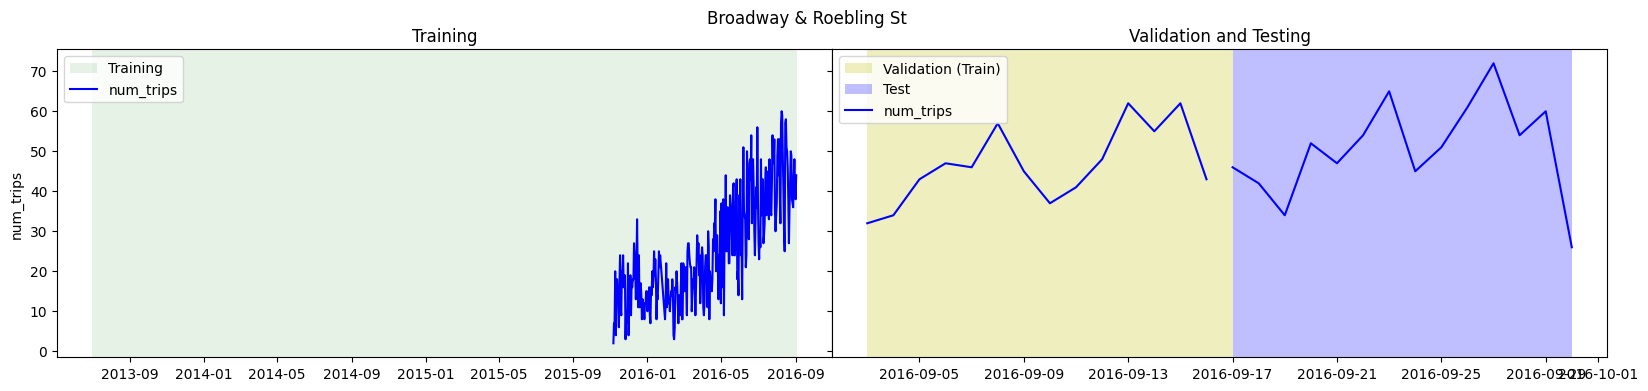

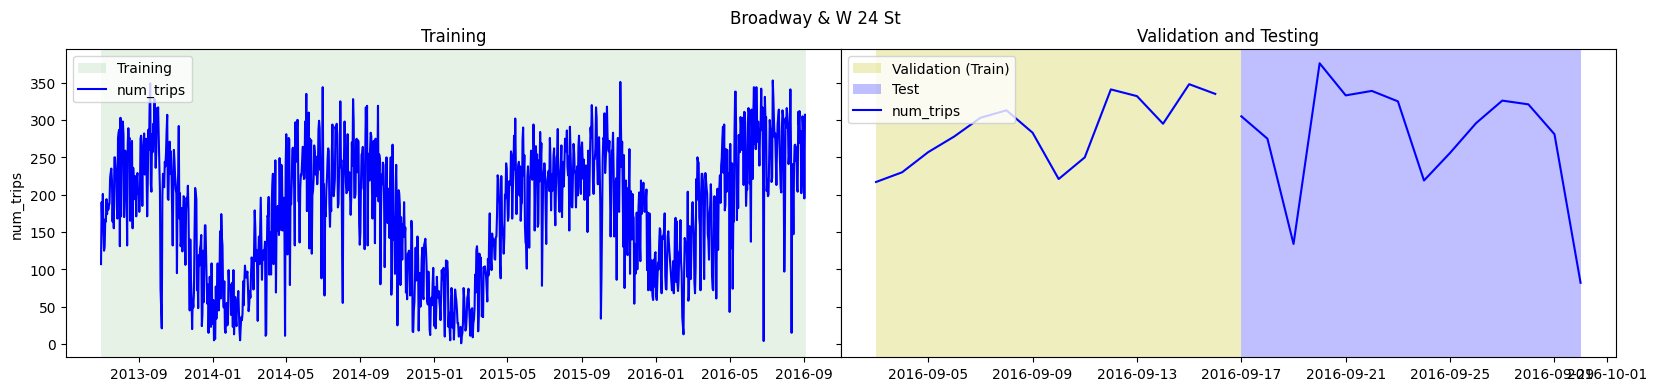

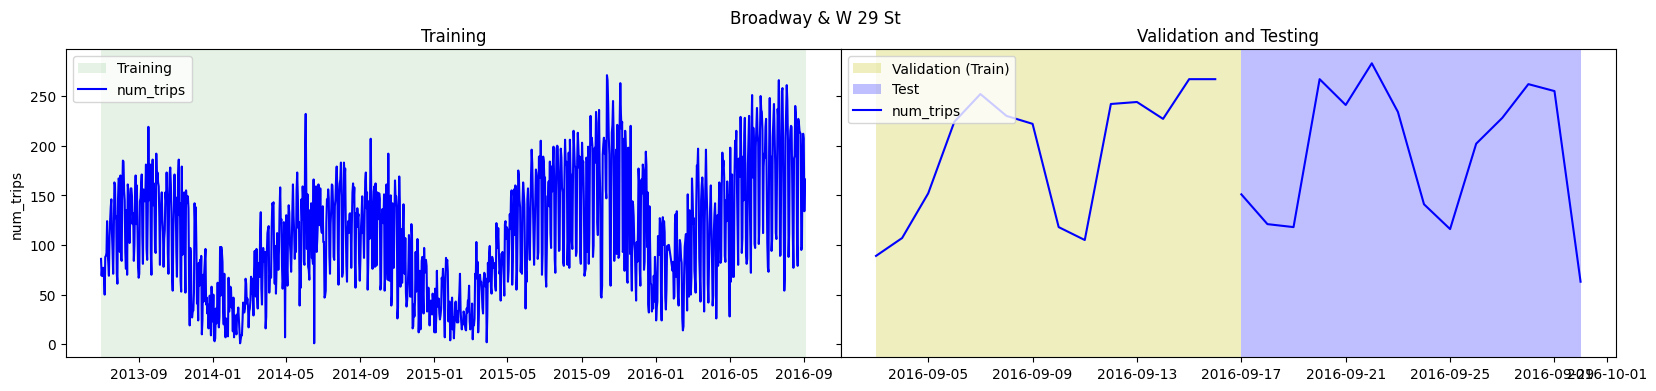

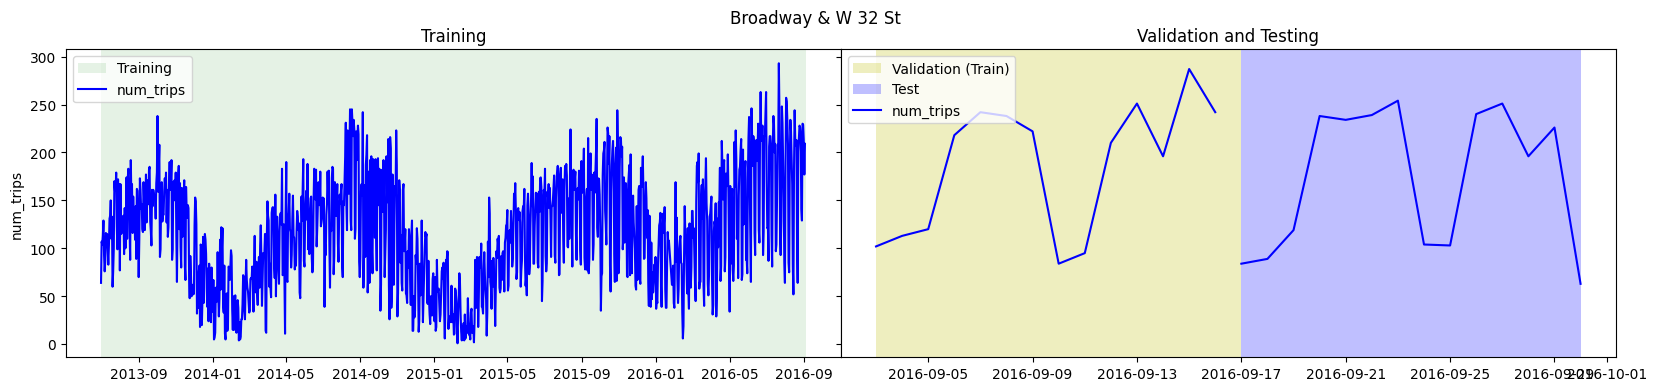

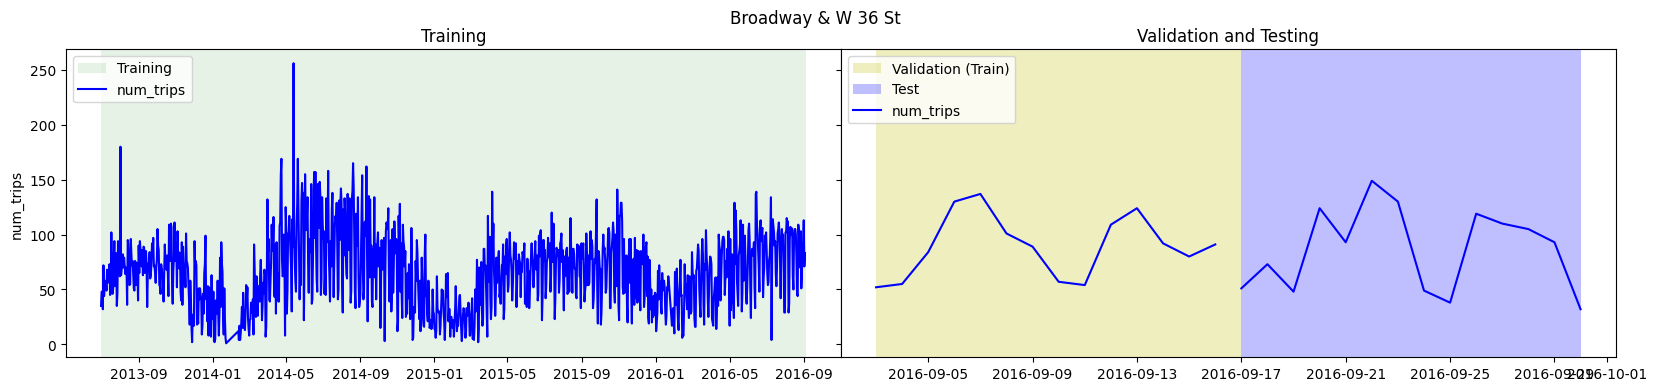

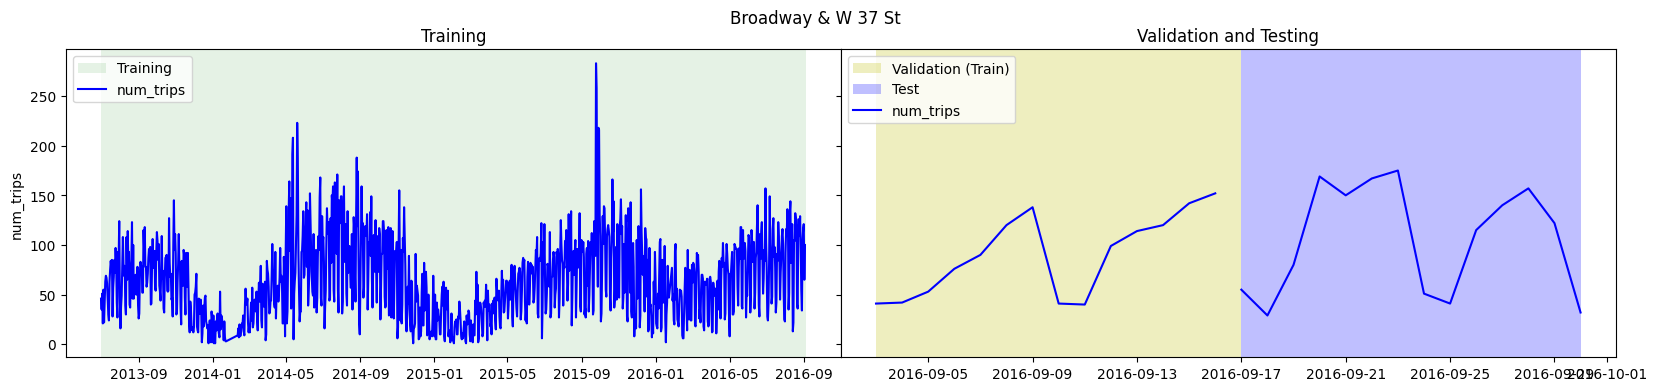

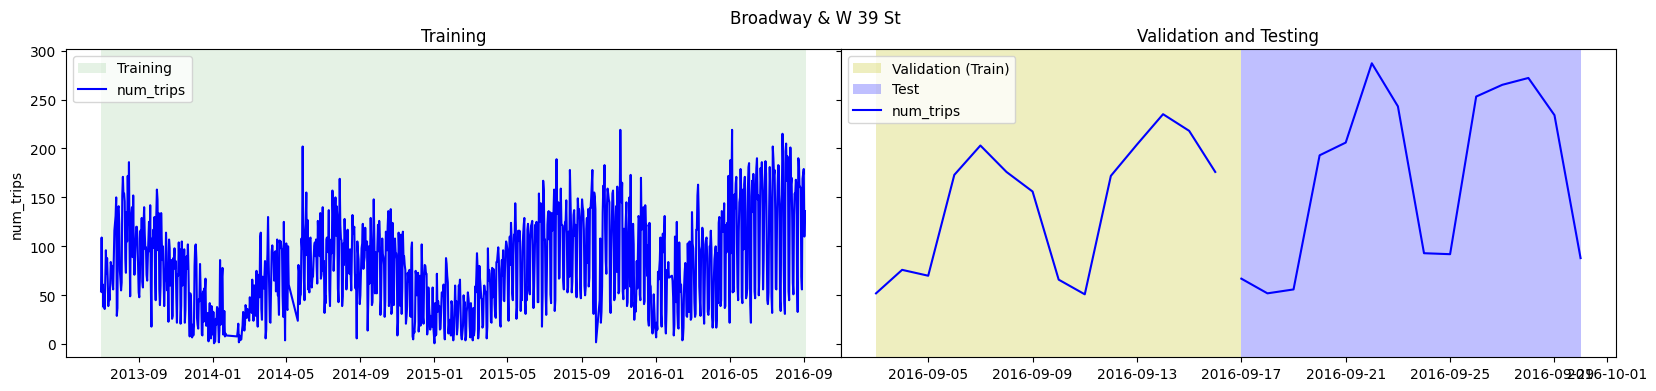

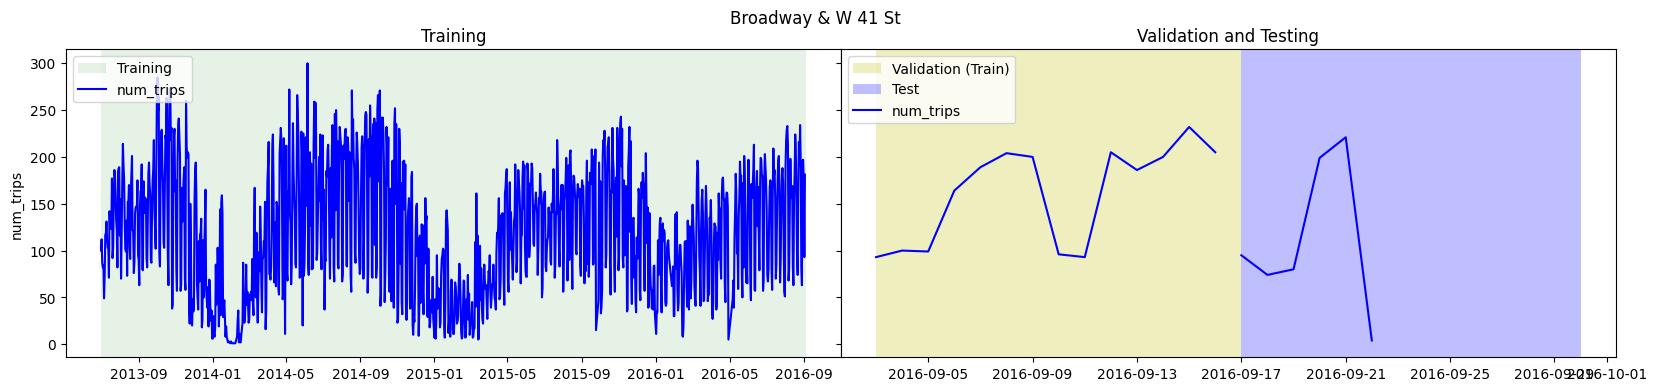

In [44]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

## Control Group Datasets

In [51]:
CONTROL_GROUP='control_group'
CONTROL_GROUP_A="Group_A"
CONTROL_GROUP_B="Group_B"

BQ_TABLE_GROUP_A="control_group1_grp_a"
BQ_TABLE_GROUP_B="control_group1_grp_b"

In [48]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_A}` AS
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    WHERE {CONTROL_GROUP} = '{CONTROL_GROUP_A}'
"""
job = bq_client.query(query)
job.result()
(job.ended-job.started).total_seconds()

1.562

In [49]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_B}` AS
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    WHERE {CONTROL_GROUP} = '{CONTROL_GROUP_B}'
"""
job = bq_client.query(query)
job.result()
(job.ended-job.started).total_seconds()

1.515

## Review forecast data - Control Group A

In [52]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_A}`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

start_station_name  TRAIN  VALIDATE  TEST  num_trips
0     Boerum St & Broadway    187         8     3       2217
1    Broadway & Battery Pl    543         7     8      50263
2      Broadway & Berry St    584         9     6      16939
3       Broadway & E 14 St    579         7     8     122590
4       Broadway & E 22 St    570         7     5     116018
5   Broadway & Roebling St    137         7    11       4583
6       Broadway & W 24 St    551         4     7      99600
7       Broadway & W 29 St    597         9     5      67835
8       Broadway & W 32 St    562         9     9      69143
9       Broadway & W 36 St    595         7     7      39987
10      Broadway & W 37 St    588        10     8      39538
11      Broadway & W 39 St    580         6     7      48144

In [53]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       16558
VALIDATE      288
TEST          271
dtype: int64

In [54]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

17117

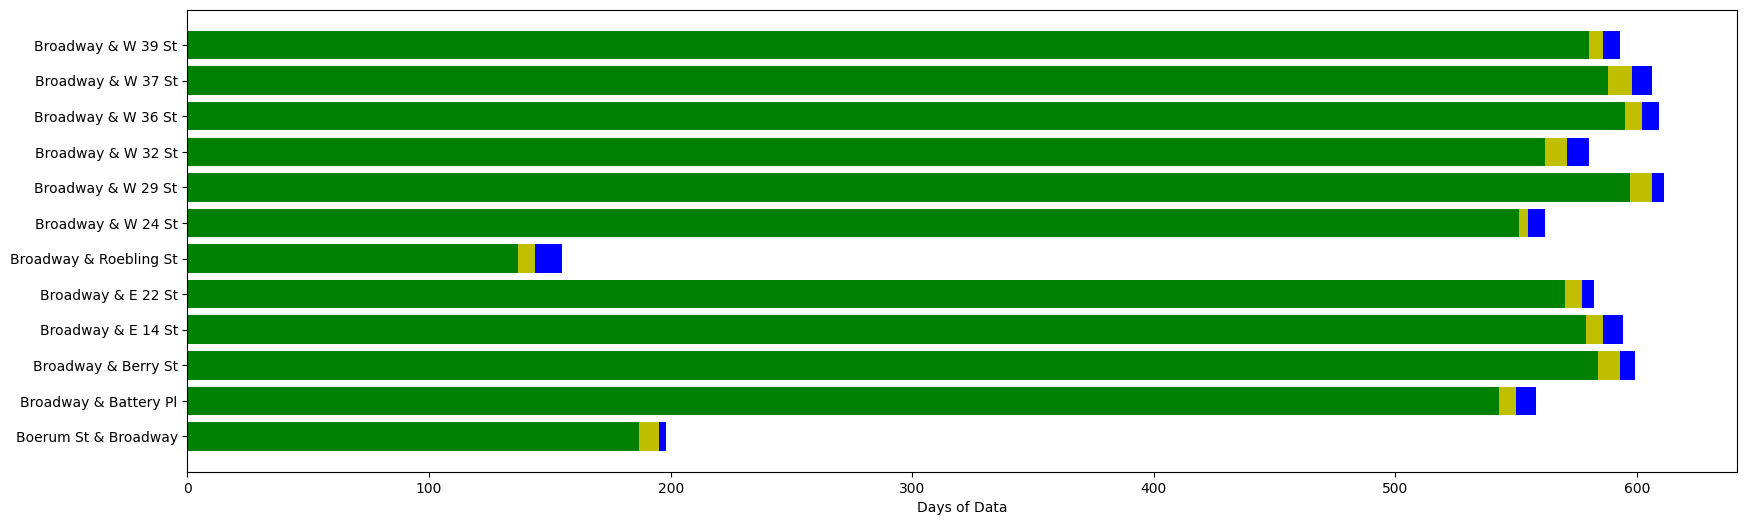

In [55]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

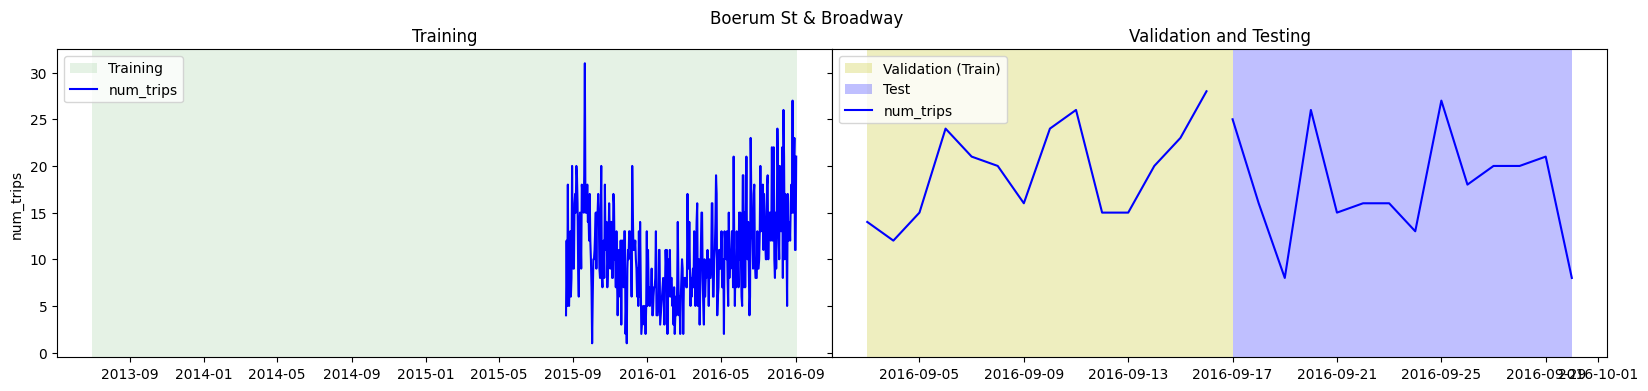

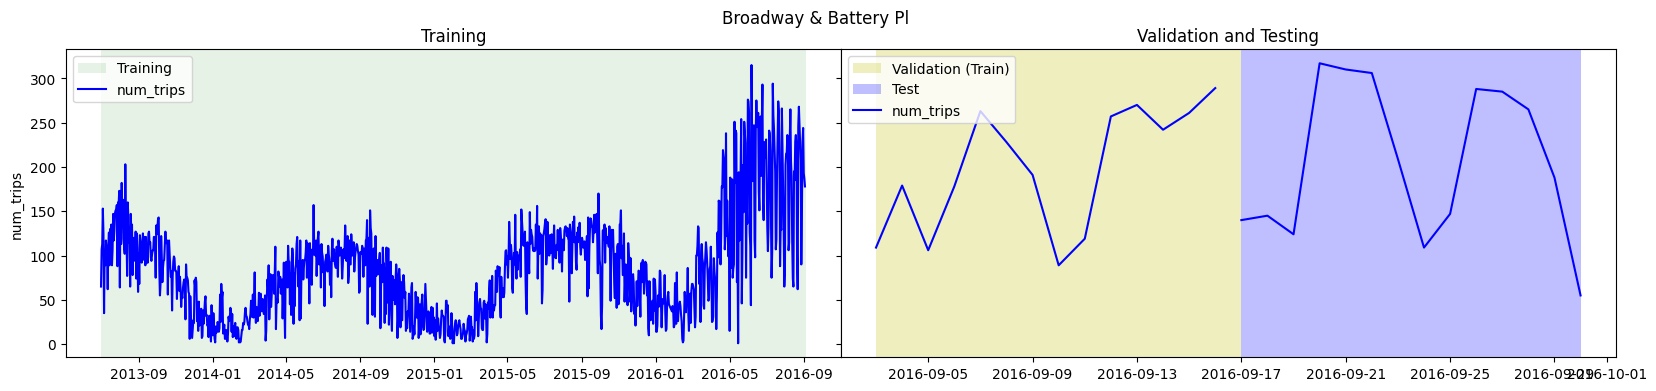

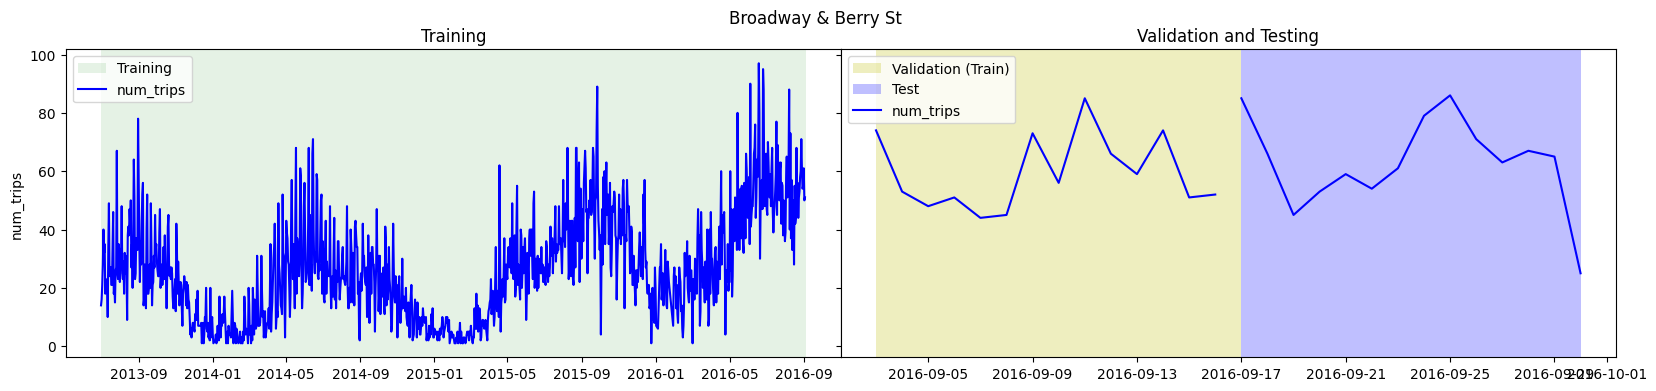

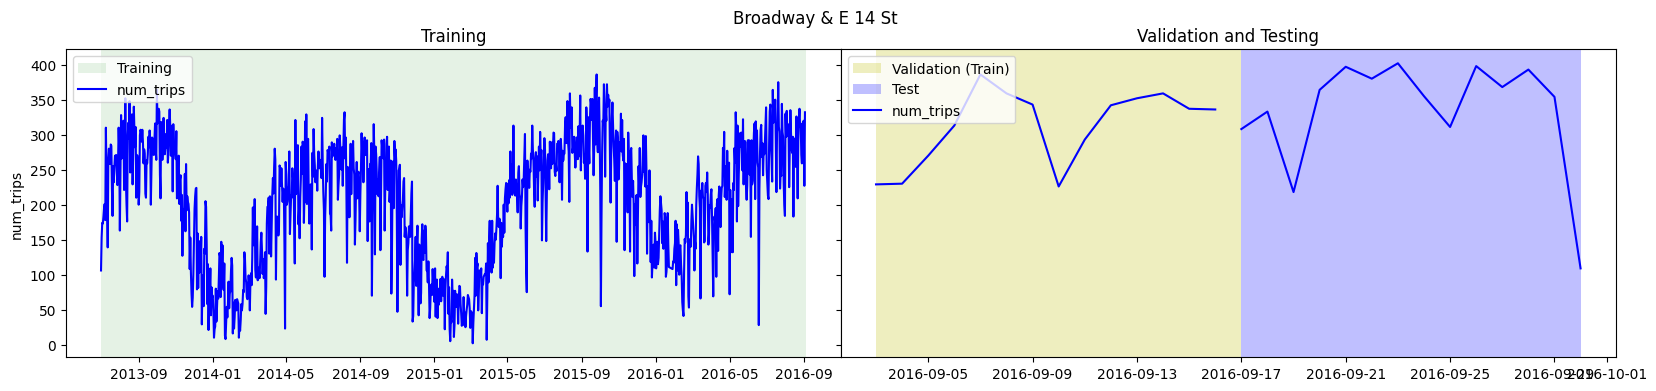

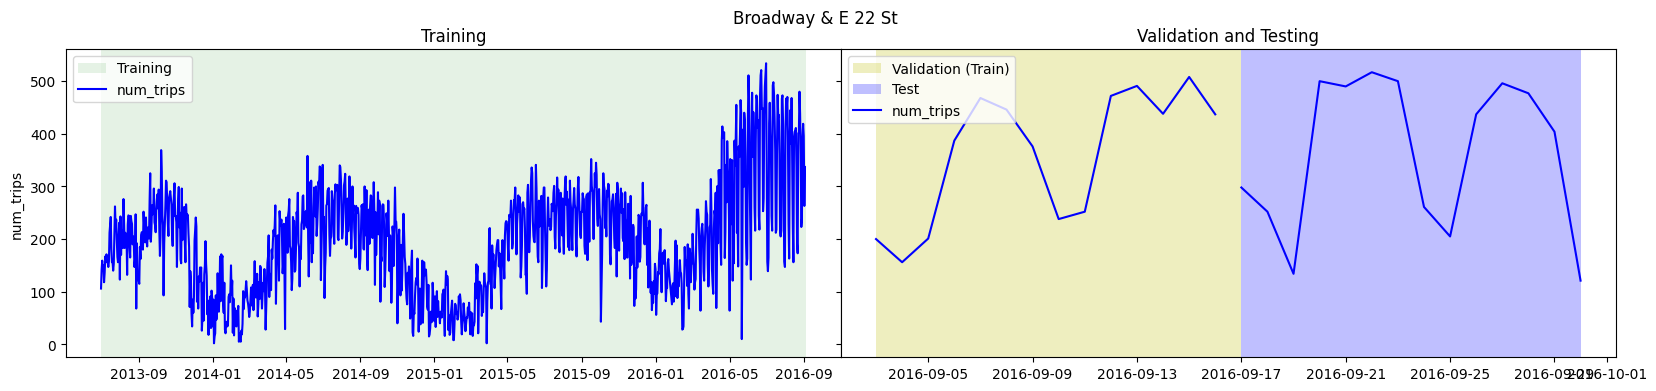

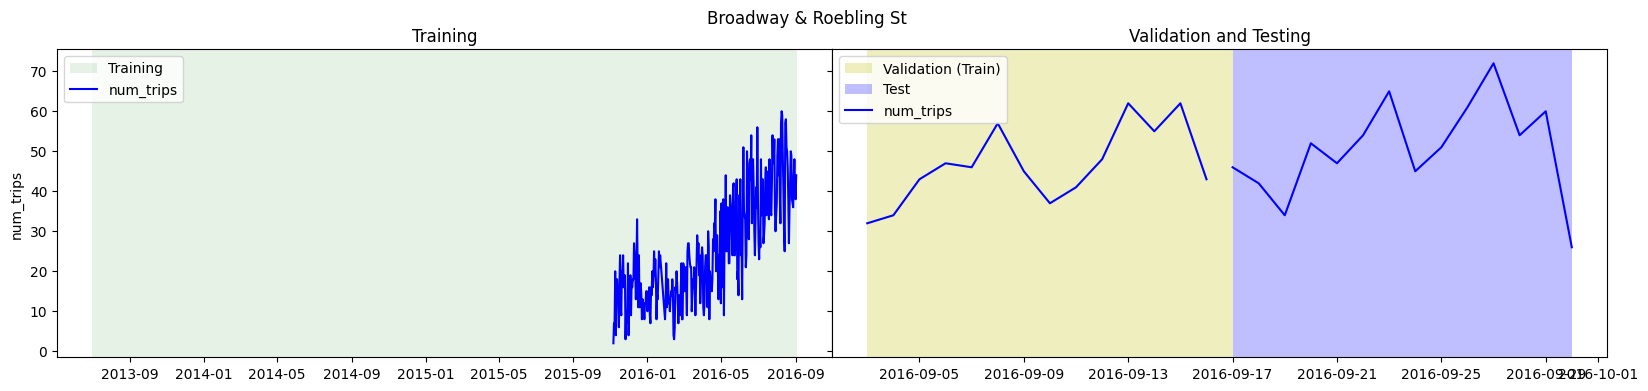

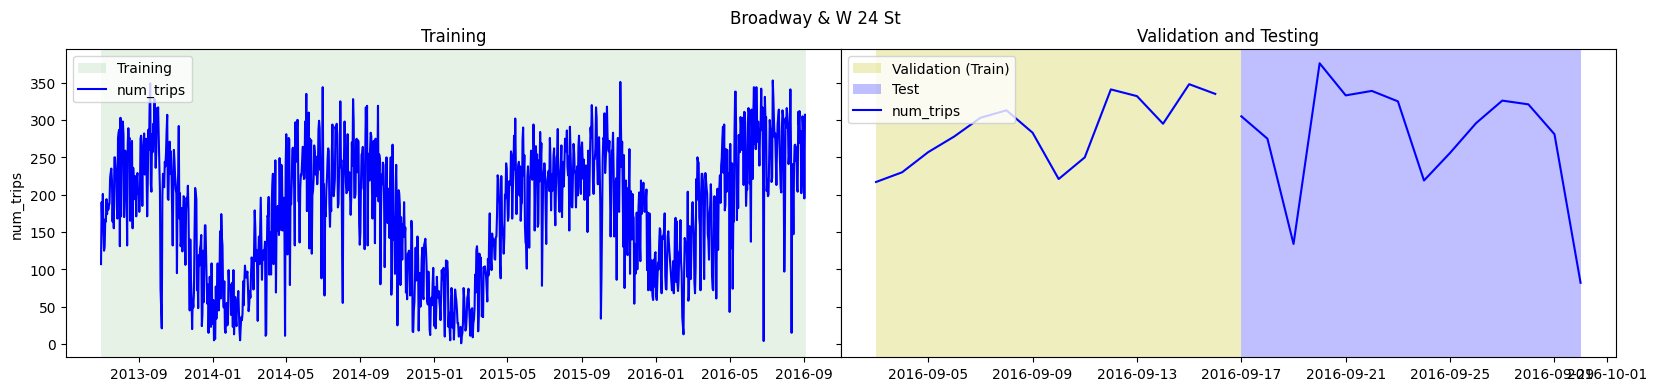

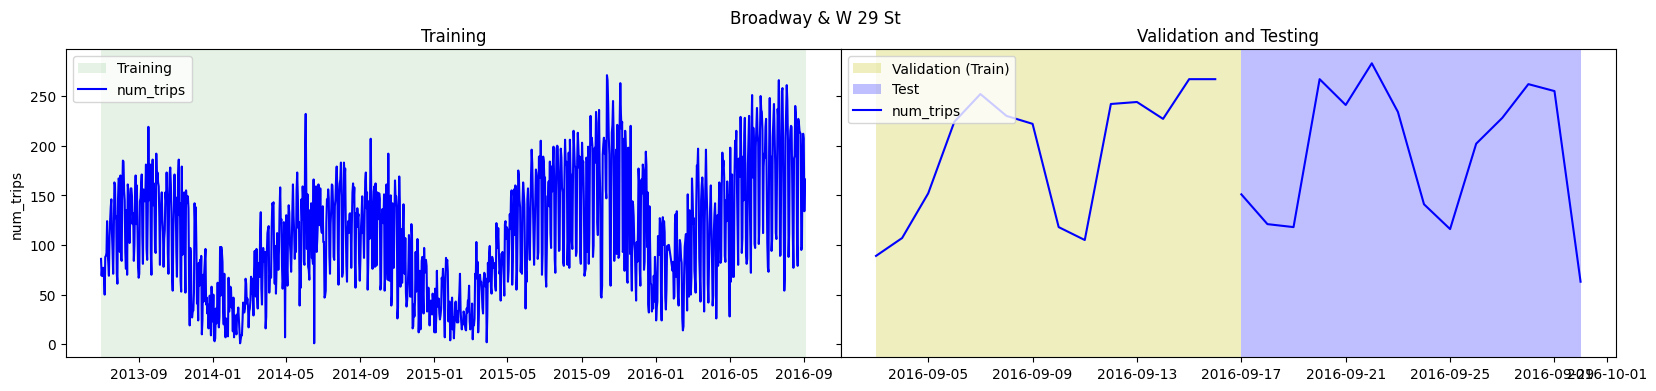

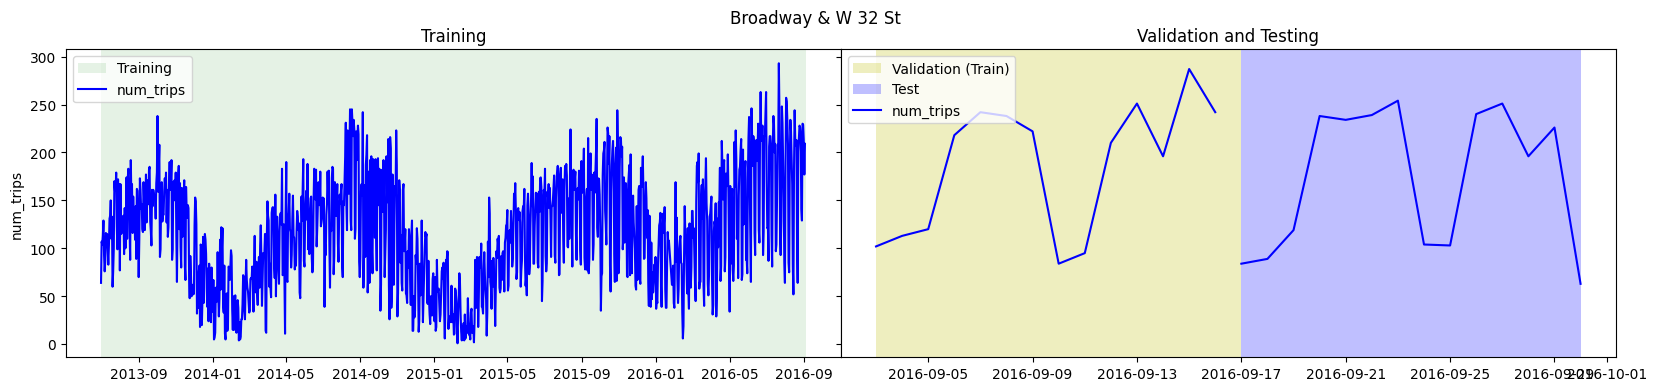

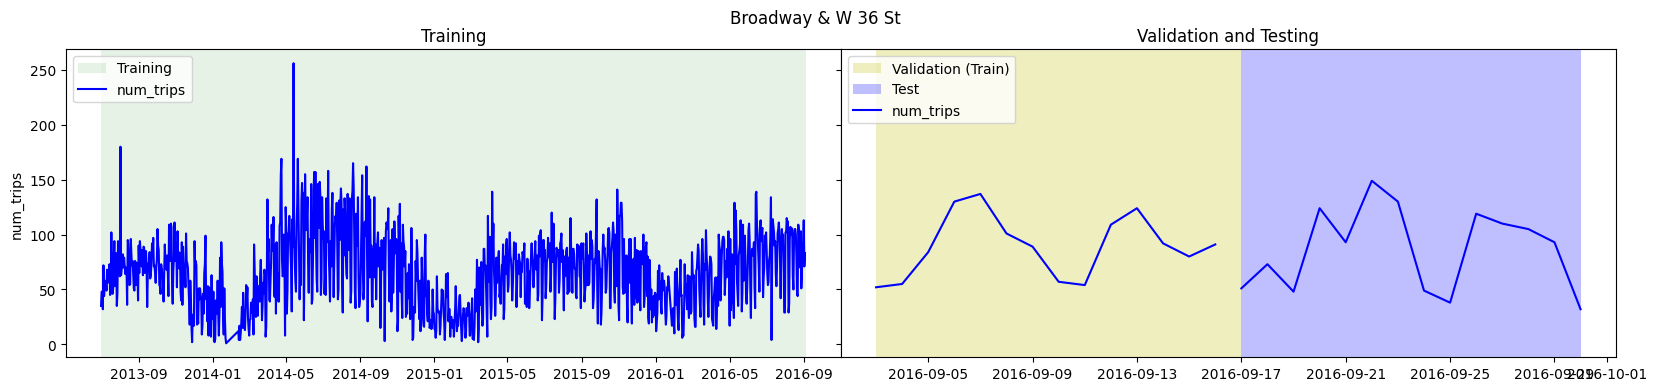

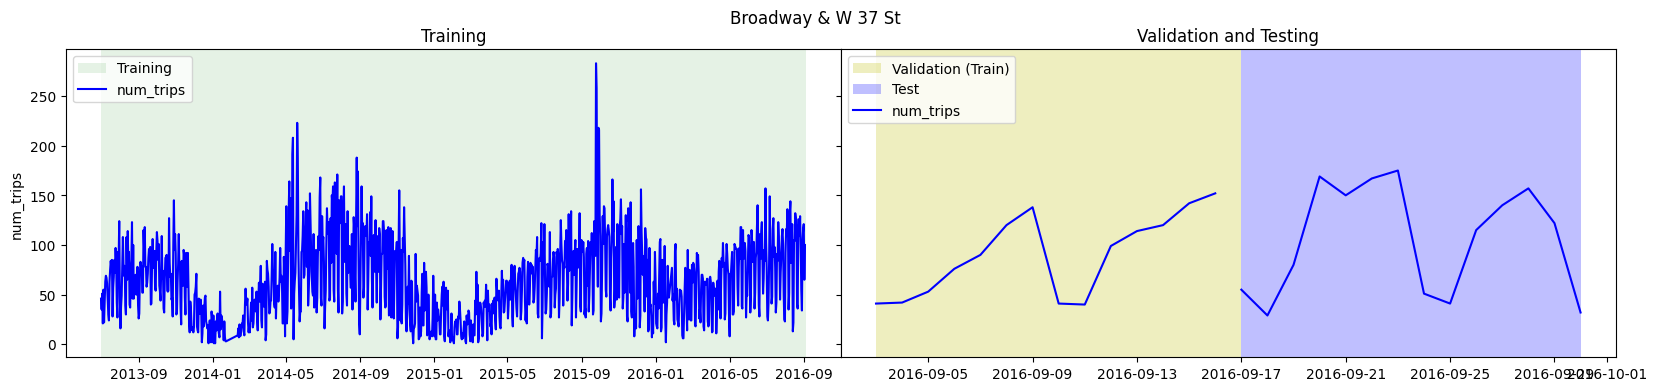

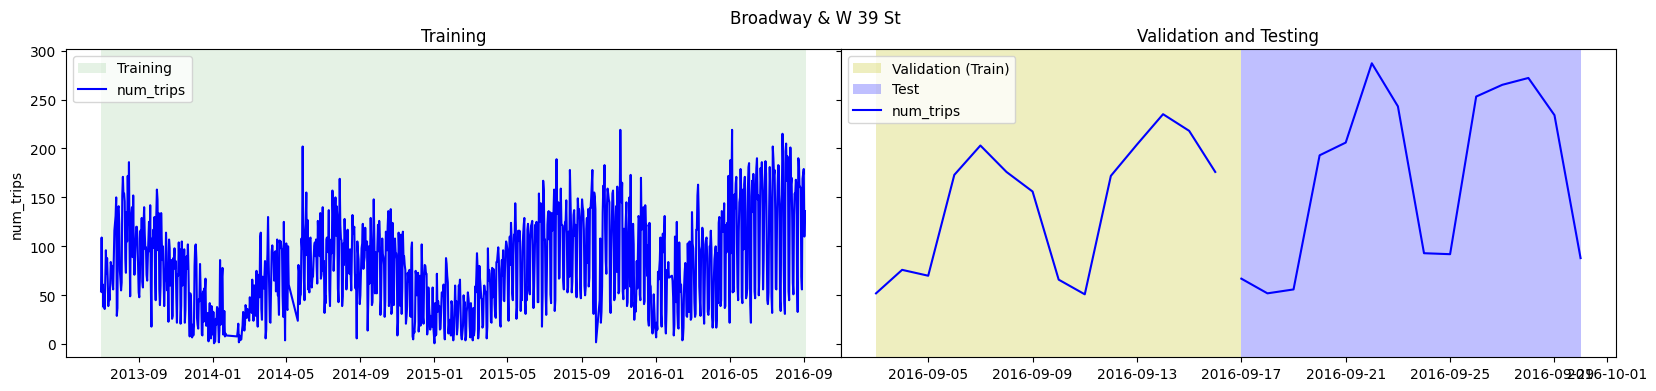

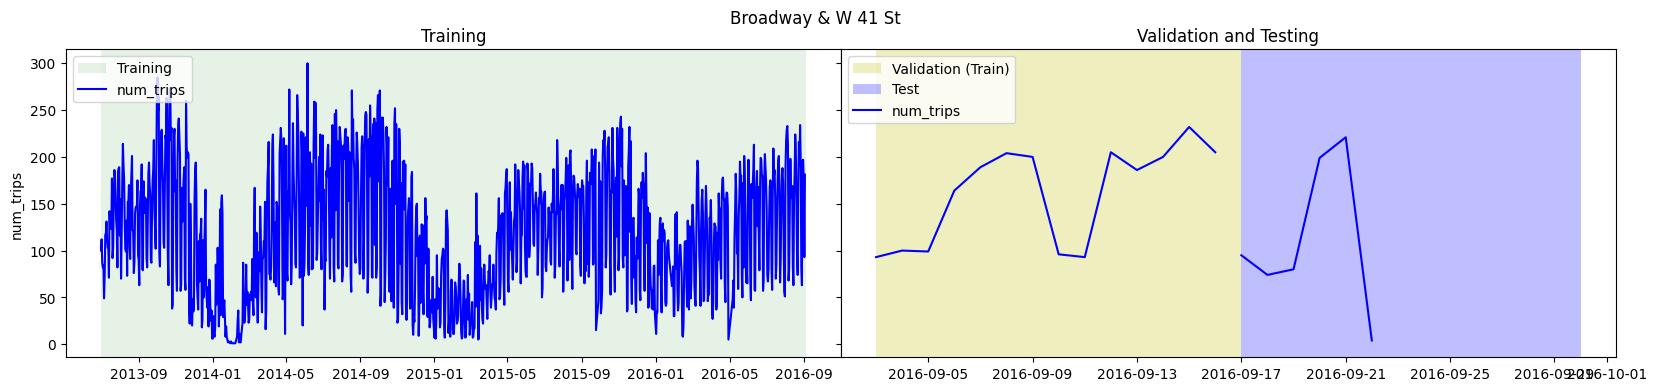

In [56]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

## Review forecast data - Control Group B

In [57]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_B}`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

start_station_name  TRAIN  VALIDATE  TEST  num_trips
0     Boerum St & Broadway    189         6    11       2343
1    Broadway & Battery Pl    612         7     6      53863
2      Broadway & Berry St    550         5     8      15074
3       Broadway & E 14 St    576         7     6     121830
4       Broadway & E 22 St    586         7     9     121376
5   Broadway & Roebling St    159         7     3       4253
6       Broadway & W 24 St    599        10     7     112113
7       Broadway & W 29 St    557         5     9      64665
8       Broadway & W 32 St    589         5     5      69669
9       Broadway & W 36 St    540         7     7      36914
10      Broadway & W 37 St    546         4     6      35709
11      Broadway & W 39 St    536         8     7      46132

In [58]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       16474
VALIDATE      258
TEST          267
dtype: int64

In [59]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

16999

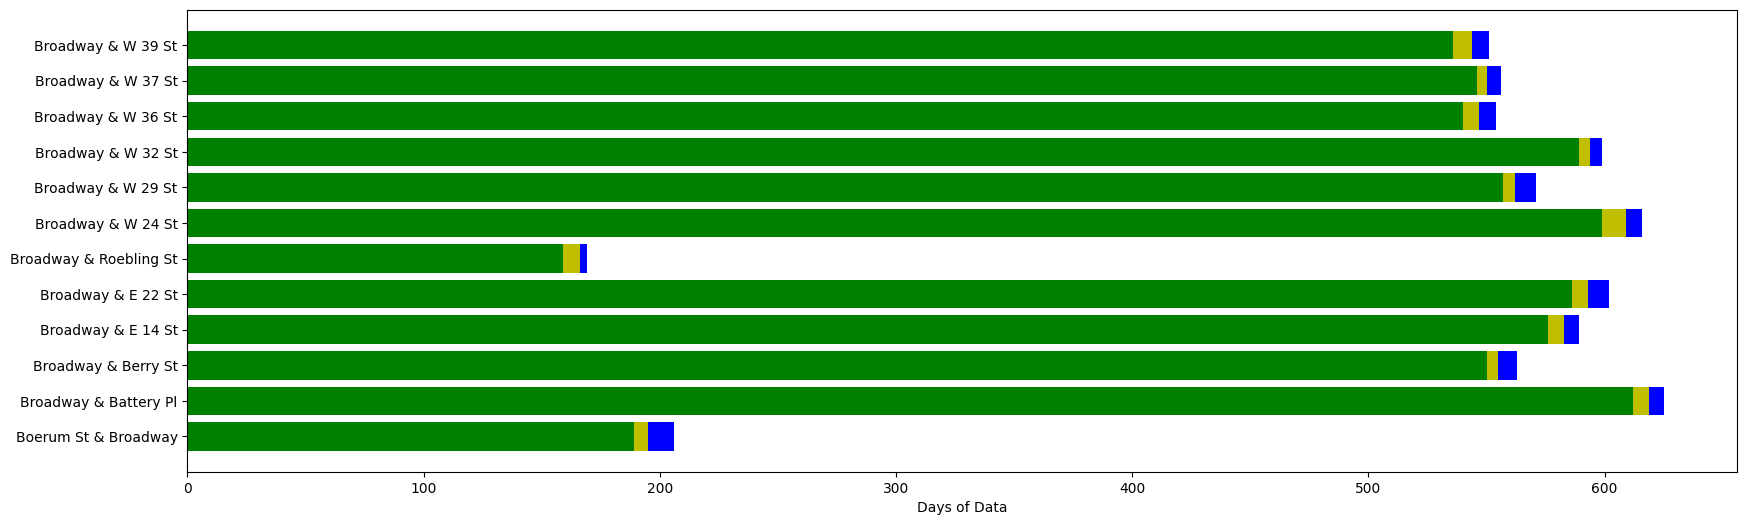

In [60]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

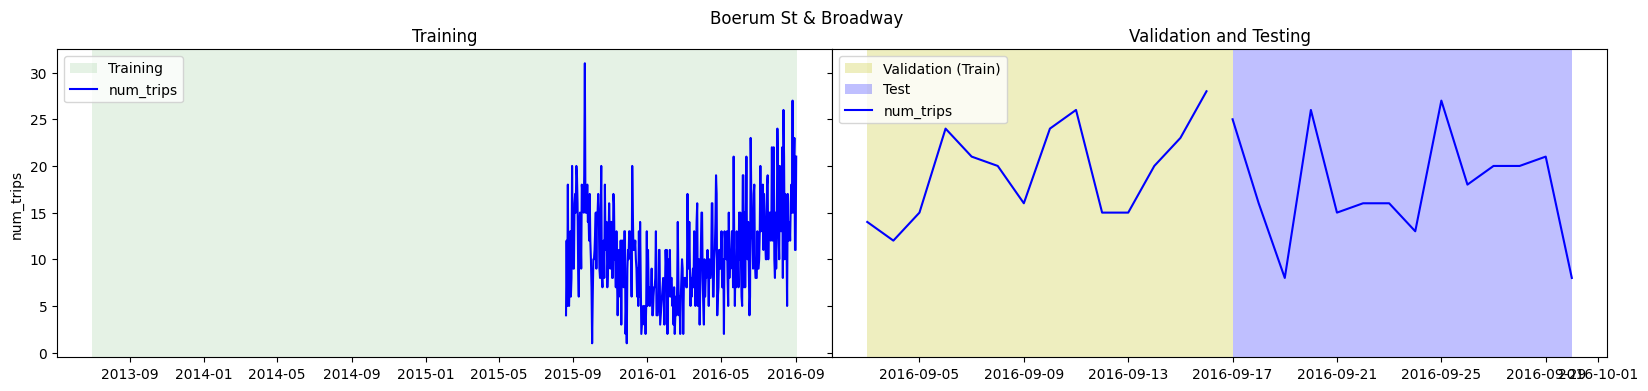

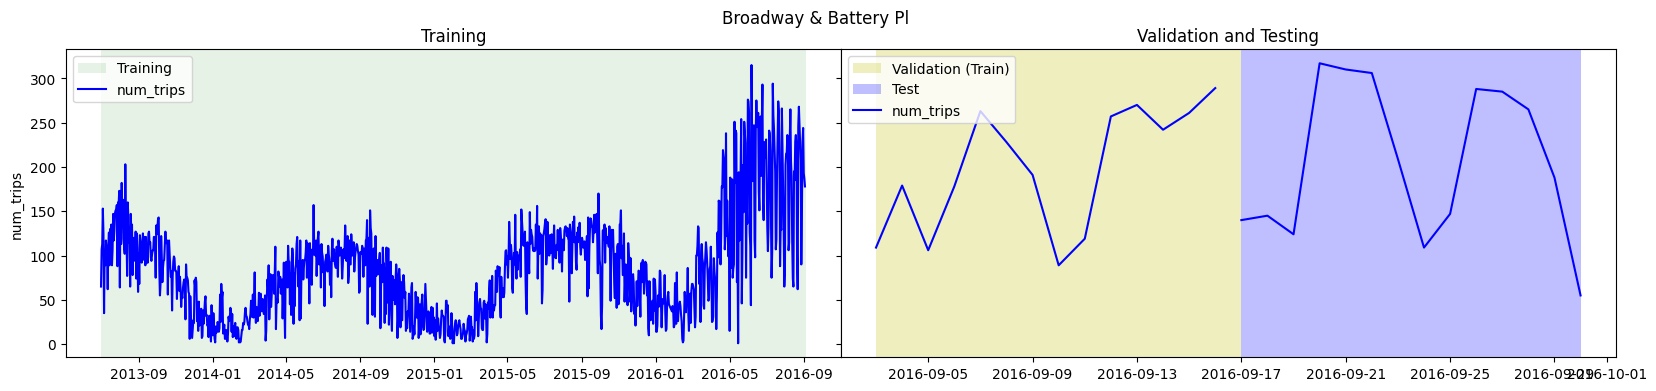

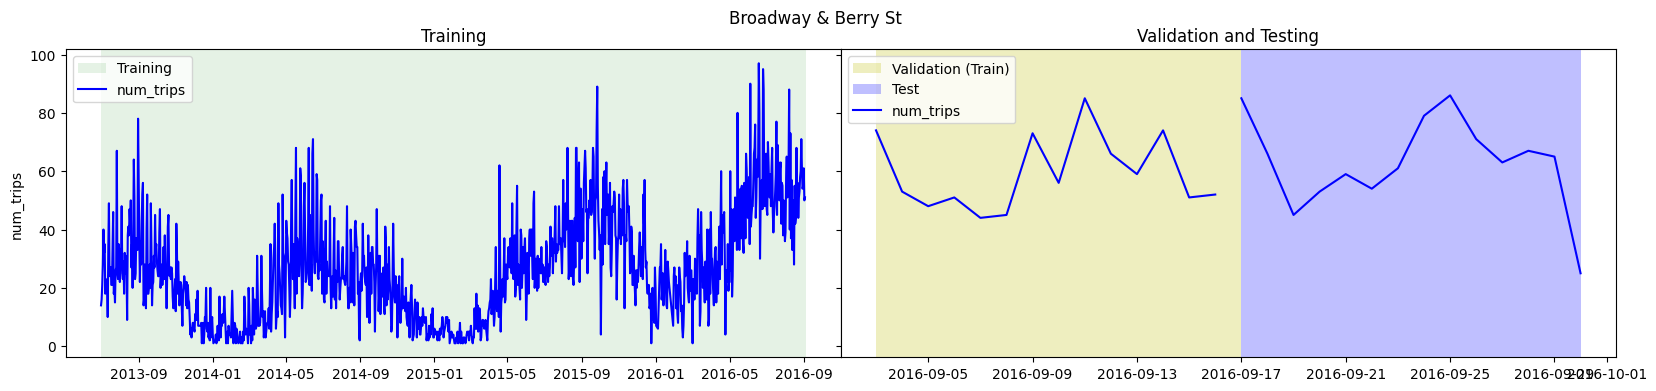

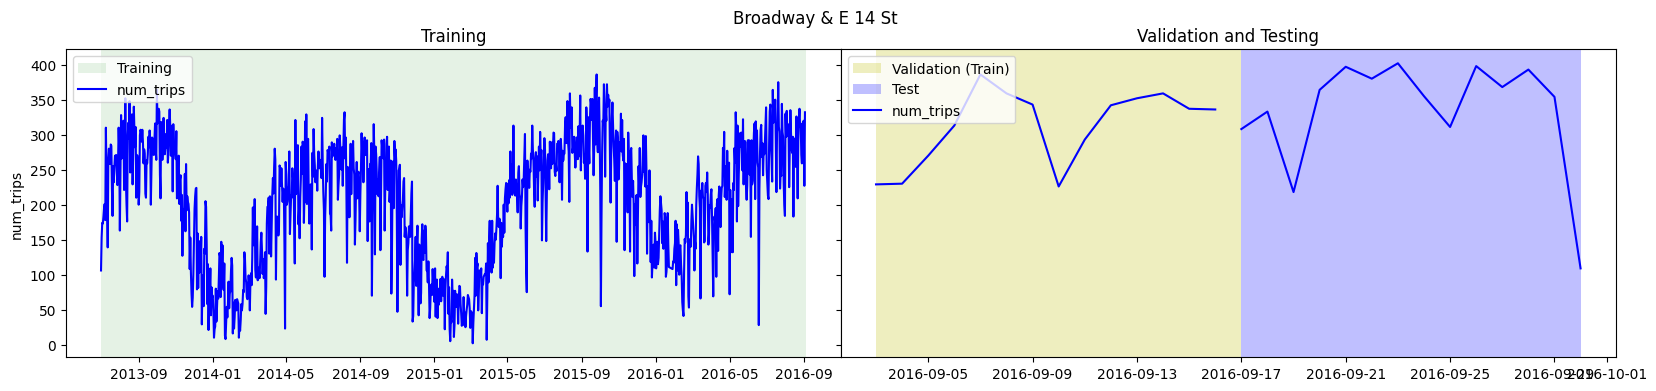

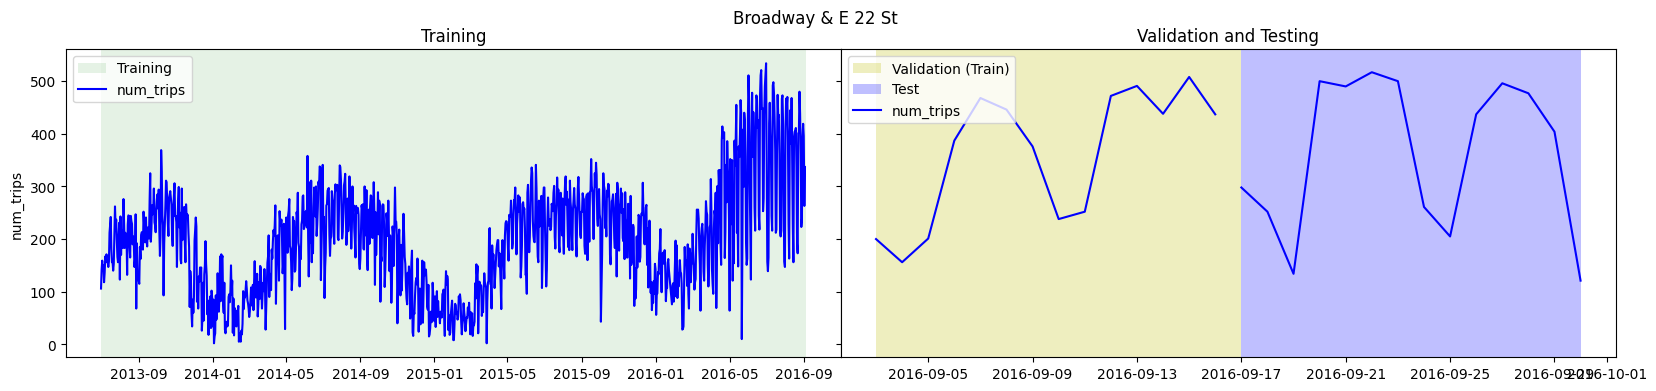

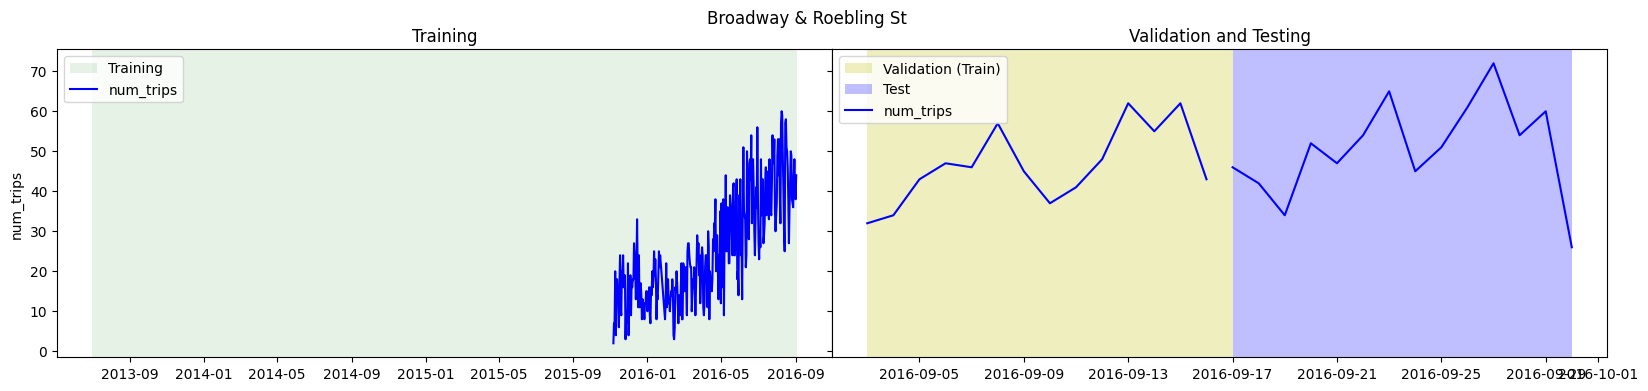

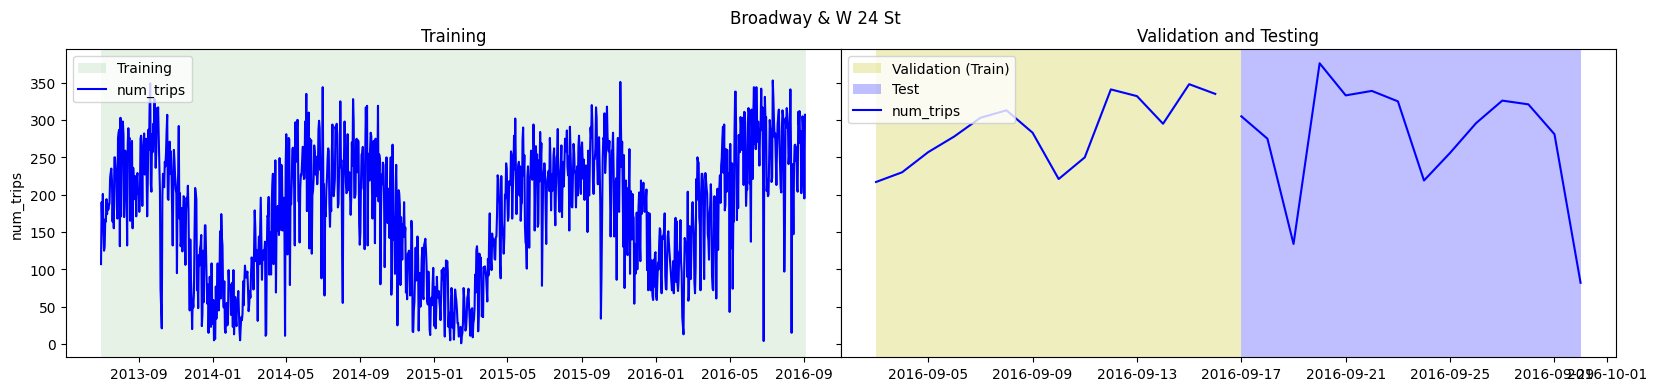

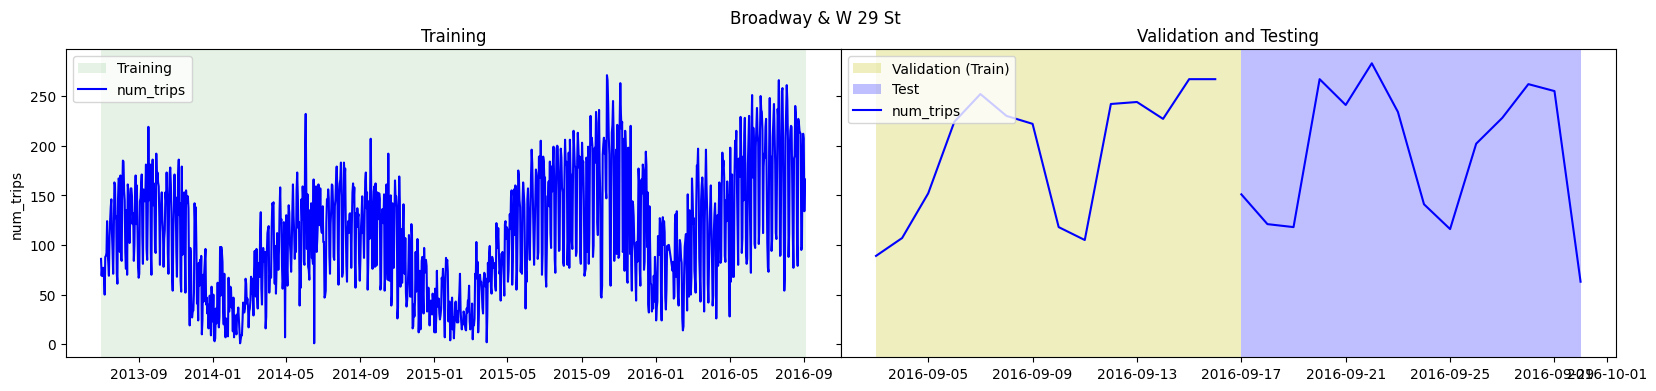

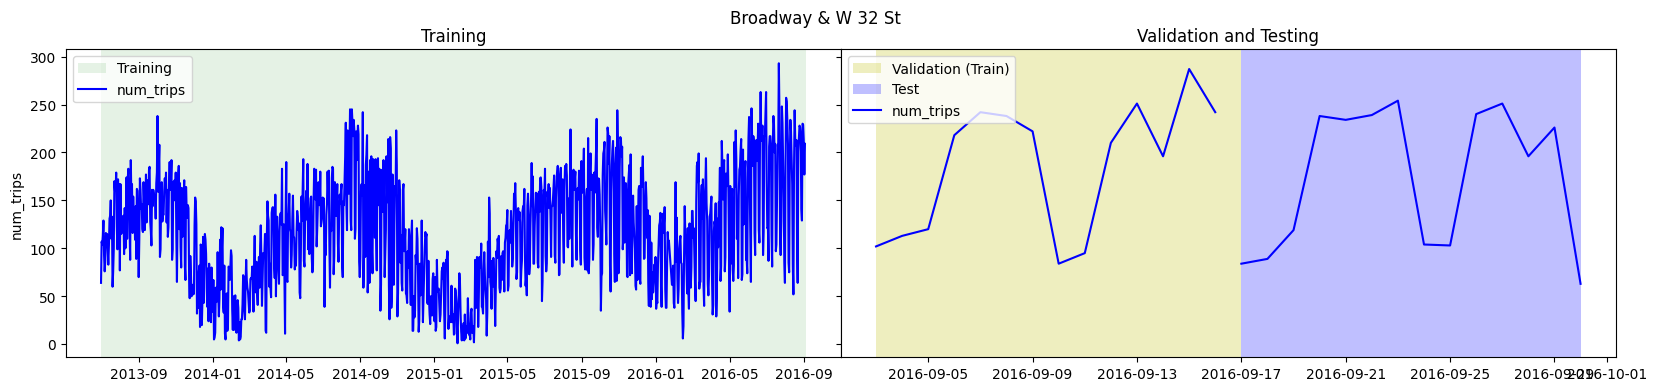

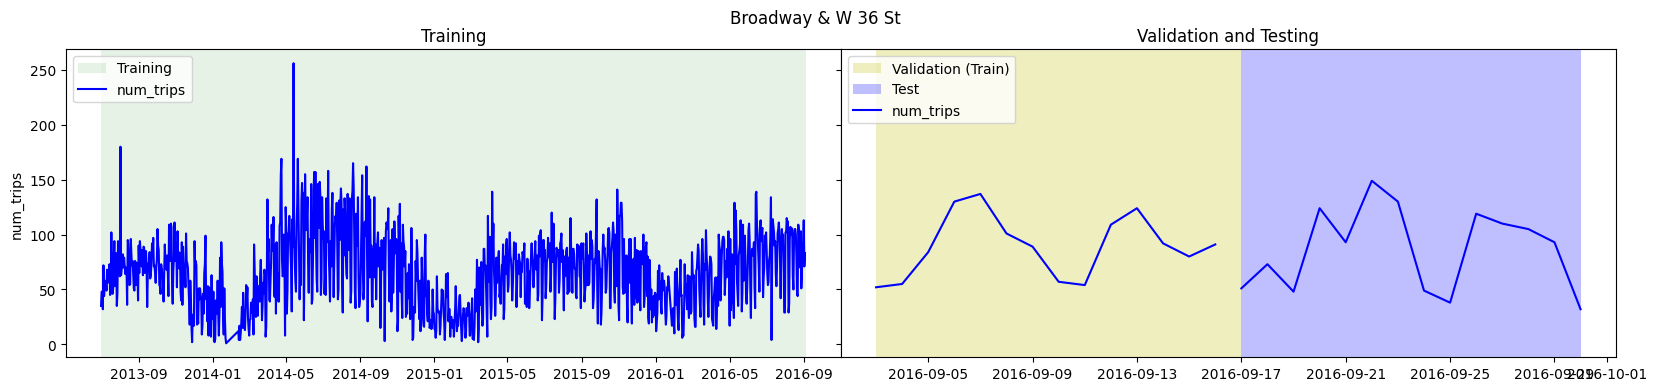

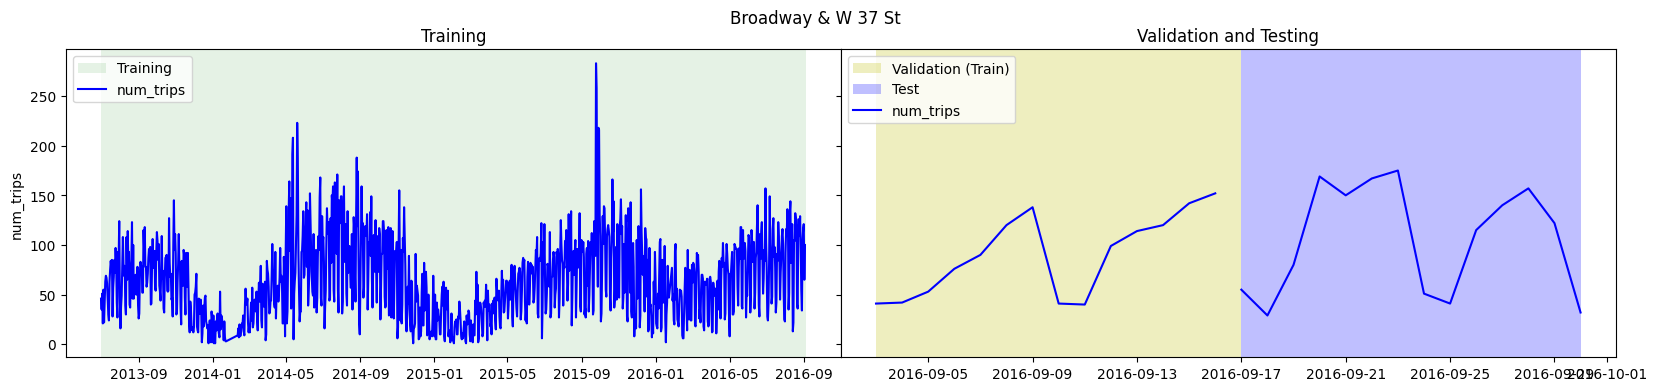

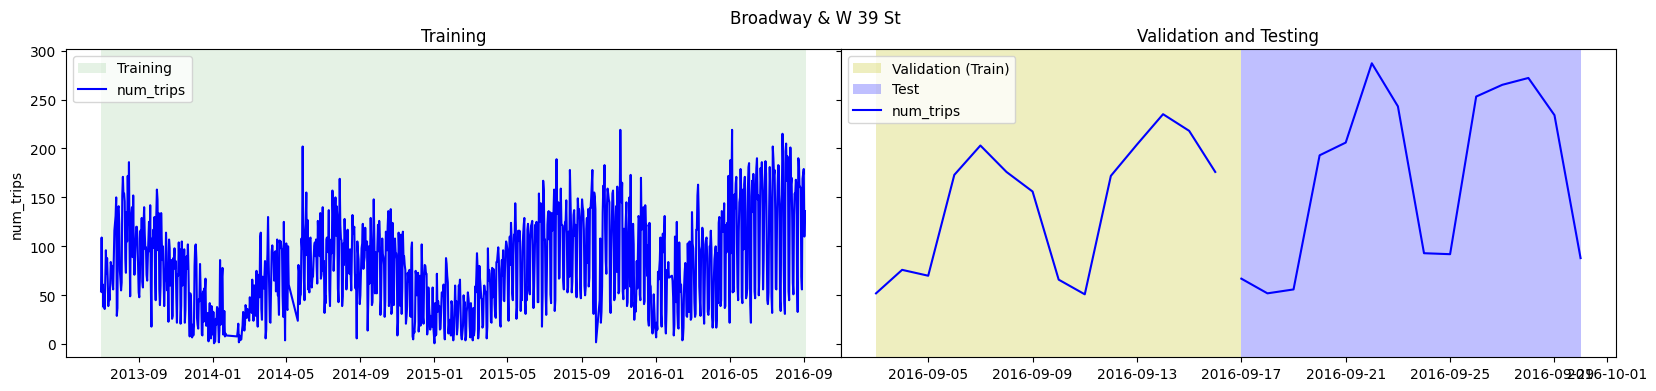

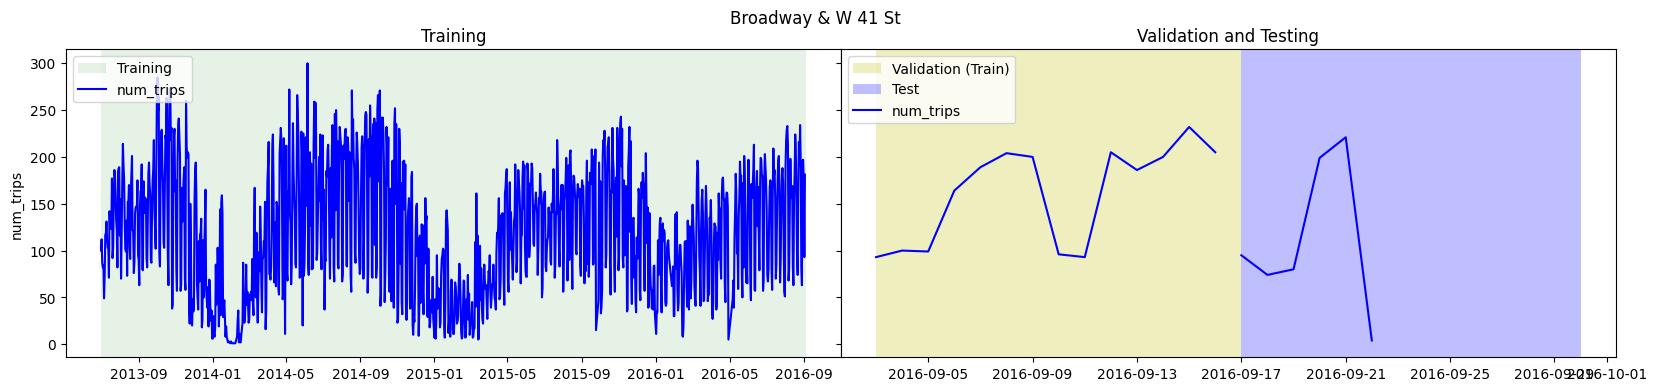

In [61]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()